<h1>Restaurant Recommender System For AnimoEats</h1>

This recommendation system, built with TensorFlow, employs User-Item Collaborative Filtering to suggest the top three restaurants that best suit the concurrent user.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

# Assume you have a DataFrame named 'data' with the specified columns

data = pd.read_csv("orders.csv")

# Convert categorical features to numerical codes
data['customer_id'] = data['customer_id'].astype("category").cat.codes
data['vendor_id'] = data['vendor_id'].astype("category").cat.codes

# Split the data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Define the embedding size
embedding_size = 10

# Define the input layers
customer_input = Input(shape=(1,), name='customer_input')
vendor_input = Input(shape=(1,), name='vendor_input')
other_features_input = Input(shape=(6,), name='other_features_input')  # Assuming 7 additional features

# Embedding layers for customer and vendor
customer_embedding = Embedding(input_dim=data['customer_id'].nunique(), output_dim=embedding_size, input_length=1)(customer_input)
vendor_embedding = Embedding(input_dim=data['vendor_id'].nunique(), output_dim=embedding_size, input_length=1)(vendor_input)

# Flatten the embeddings
customer_flatten = Flatten()(customer_embedding)
vendor_flatten = Flatten()(vendor_embedding)

# Concatenate the flattened embeddings with other features
concatenated = Concatenate()([customer_flatten, vendor_flatten, other_features_input])

# Dense layers for the neural network
dense1 = Dense(50, activation='relu')(concatenated)
dense2 = Dense(20, activation='relu')(dense1)
output = Dense(1)(dense2)

# Create and compile the model
model = Model(inputs=[customer_input, vendor_input, other_features_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history = model.fit(
    [train_df['customer_id'], train_df['vendor_id'], train_df[['item_count', 'grand_total_php', 'deliverydistance', 'preparationtime', 'LOCATION_NUMBER', 'vendor_rating']]],
    train_df['vendor_rating'],
    epochs=30,
    batch_size=1,
    validation_data=([test_df['customer_id'], test_df['vendor_id'], test_df[['item_count', 'grand_total_php', 'deliverydistance', 'preparationtime', 'LOCATION_NUMBER', 'vendor_rating']]], test_df['vendor_rating']),
    verbose=1
)


Epoch 1/30
14887/14887 [==============================] - 18s 1ms/step - loss: 32.3015 - mae: 1.8566 - mse: 32.3015 - val_loss: 0.3841 - val_mae: 0.4090 - val_mse: 0.3841
Epoch 2/30
14887/14887 [==============================] - 18s 1ms/step - loss: 0.9768 - mae: 0.5583 - mse: 0.9768 - val_loss: 0.0442 - val_mae: 0.1622 - val_mse: 0.0442
Epoch 3/30
14887/14887 [==============================] - 19s 1ms/step - loss: 0.1795 - mae: 0.2006 - mse: 0.1795 - val_loss: 0.0131 - val_mae: 0.0911 - val_mse: 0.0131
Epoch 4/30
14887/14887 [==============================] - 20s 1ms/step - loss: 0.0701 - mae: 0.1442 - mse: 0.0701 - val_loss: 0.1409 - val_mae: 0.2998 - val_mse: 0.1409
Epoch 5/30
14887/14887 [==============================] - 21s 1ms/step - loss: 0.0642 - mae: 0.1280 - mse: 0.0642 - val_loss: 0.0061 - val_mae: 0.0528 - val_mse: 0.0061
Epoch 6/30
14887/14887 [==============================] - 20s 1ms/step - loss: 0.0447 - mae: 0.1033 - mse: 0.0447 - val_loss: 0.0031 - val_mae: 0.0383 - 

In [4]:
data.columns

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'grand_total_php', 'deliverydistance', 'preparationtime',
       'LOCATION_NUMBER', 'vendor_id', 'vendor_name', 'vendor_rating',
       'compound_score_conv'],
      dtype='object')

<h2>Model Training Loss & Mean Squared Error </h2>

The chart below suggests that there is little to no overfitting happened to the model as the trend of the training loss is continuously going down. 

The MSE we attained on this model is : Mean Squared Error (MSE): 0.0.00021267746259287978

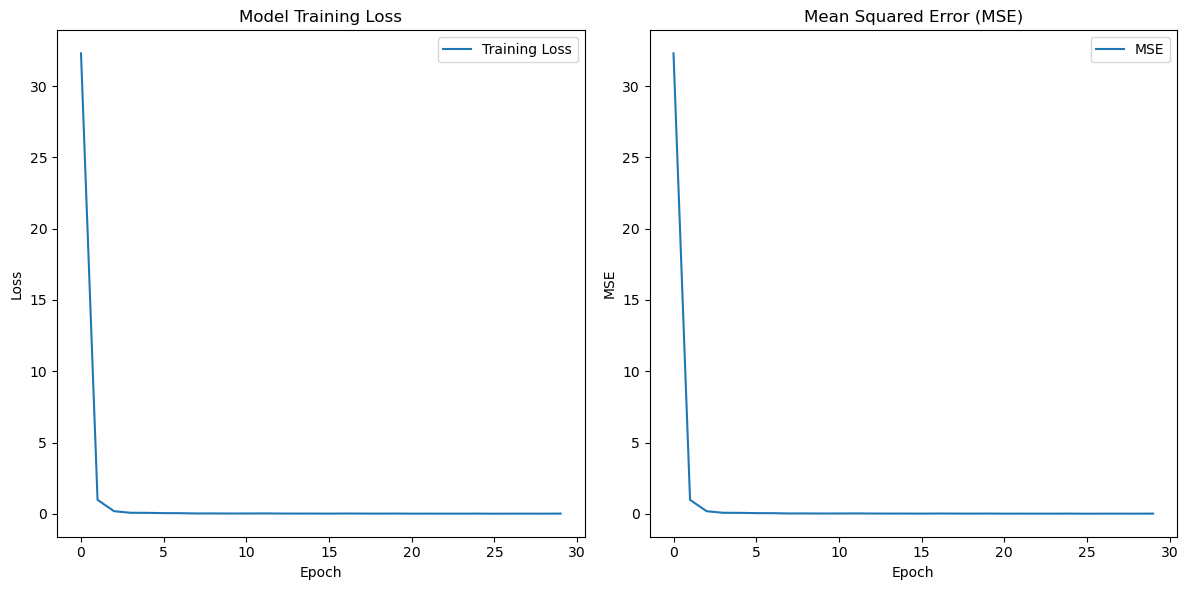

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

# Create a color map for vendor ratings
color_map = sns.color_palette("viridis", as_cmap=True)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MSE
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='MSE')  # Assuming 'mse' is part of the model metrics
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Assuming 'model' is already trained, you can use the following code to generate recommendations

# Generate recommendations for a specific user
user_id_to_recommend_for = 2  # Replace with the user ID you want to recommend for
user_rated_vendors = train_df[train_df['customer_id'] == user_id_to_recommend_for]['vendor_id']

# Create input for the model
user_input = np.full(len(data['vendor_id'].unique()), user_id_to_recommend_for)
other_features_input = data[data['customer_id'] == user_id_to_recommend_for][['item_count', 'grand_total_php', 'deliverydistance', 'preparationtime', 'LOCATION_NUMBER', 'vendor_rating']].values

# Predict ratings for all vendors
all_vendors = pd.DataFrame({'vendor_id': data['vendor_id'].unique()})
all_vendors['predicted_rating'] = model.predict([user_input, all_vendors['vendor_id'], np.tile(other_features_input, (len(all_vendors), 1))])

# Merge with the original data to get vendor information
all_vendors = pd.merge(all_vendors, data[['vendor_id', 'vendor_name', 'vendor_rating']], on='vendor_id', how='left')

# Sort vendors by predicted rating in descending order
recommended_vendors = all_vendors.sort_values(by='predicted_rating', ascending=False)

# Exclude vendors already rated by the user
recommended_vendors = recommended_vendors[~recommended_vendors['vendor_id'].isin(user_rated_vendors)]

# Get the top 3 recommendations
top_recommendations = recommended_vendors.groupby('vendor_name').head(1).head(3)[['vendor_id', 'vendor_name', 'predicted_rating']]

print(f"Recommendations for User {user_id_to_recommend_for}:\n{top_recommendations}")


1/1 [==============================] - 0s 230ms/step
Recommendations for User 2:
       vendor_id            vendor_name  predicted_rating
13335          3  Lolo Thomas' Catering          4.002783
14202          8              GrilledUp          4.001440
8867           7                Ayumers          4.000275


In [7]:
from sklearn.metrics import mean_squared_error

# Get model predictions on the test set
input_columns = ['item_count', 'grand_total_php', 'deliverydistance', 'preparationtime', 'LOCATION_NUMBER', 'vendor_rating']
predictions = model.predict([test_df['customer_id'].values, test_df['vendor_id'].values, test_df[input_columns].values])

# Flatten the predictions (assuming output is a single value per prediction)
predictions = predictions.flatten()

# Calculate Mean Squared Error
mse = mean_squared_error(test_df['vendor_rating'], predictions)

print(f"Mean Squared Error (MSE): {mse}")


117/117 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 0.00021267746259287978


<h2>Model Conversion to Tensorflow Lite </h2>

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Assuming 'model' is already trained

# Save the Keras model to a file
model.save('recommendation_model.h5')

# Load the saved model
loaded_model = keras.models.load_model('recommendation_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('recommendation_model.tflite', 'wb') as f:
    f.write(tflite_model)

# You can now download 'recommendation_model.tflite' and use it for inference on mobile or edge devices.


C:\Users\Mark Spencer\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\MARKSP~1\AppData\Local\Temp\tmpvc0pcmwe\assets


INFO:tensorflow:Assets written to: C:\Users\MARKSP~1\AppData\Local\Temp\tmpvc0pcmwe\assets
